# STAT 201 Group 3 Project Proposal

# Public Art in Vancouver

In [45]:
library(tidyverse)
library(datateachr)
library(repr)
library(digest)
library(infer)
library(broom)
library(grid)
library(gridExtra)

## Introduction

Vancouver is home to diverse cultural displays. Despite the potential benefits that community arts initiatives may bring, public art and artists as a group of people are thought to be associated with the gentrification of neighborhoods like the Downtown Eastside [(Szőke, T., &amp; Parizeau, K., 2018)](https://www.tandfonline.com/action/doSearch?AllField=%22public+art%22+and+%22community+development%22&SeriesKey=rgeo20) . Since the city of Vancouver is notorious for being the site of gentrification across many of its neighborhoods, it could be beneficial to understand the changing development of Vancouver’s communities through the lens of public art and how it develops over time. As such, for this project, our operational definition for gentrification will be the incidence of public art projects in the city of Vancouver to ultimately see if the development of public art, and thus community development, occurred simultaneously, or occurred in different neighborhoods at different times.

In this project, we will try to answer the following question: 

> Is the (mean) installation year of the public art in Downtown similar to Mount Pleasant?

The dataset we plan to work on is named 'Public Art' and is sourced from the City of Vancouver's [Open Data Portal](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&cad=rja&uact=8&ved=2ahUKEwj69K7_zZr7AhWzAjQIHdxLDqYQFnoECBoQAw&url=https%3A%2F%2Fwww.destinationvancouver.com%2Factivities%2Fsightseeing%2Fpublic-art-mini-guide%2F&usg=AOvVaw1C7YOKtvv8kVHkkdl_XYie). The dataset contains information on the location, artist, and installation date of public art in Vancouver, ranging from the early 1900s to 2022. Since the data has been updated routinely over the years, we assume that the dataset contains most of the population of interest. So for the purpose of hypothesis testing as if we only had access to a select part of the population, we'll simulate sampling by taking a sample of `n = 40` (20 from each category) of the population and conduct our analysis using that. Our population parameter is the mean because we believe it to be a suitable measure of determining when public art generally started to develop in each neighborhood. In the future, we may explore hypothesis testing with the medians.

In [2]:
# Code to download file from: https://datasciencebook.ca/reading.html
url <- "https://opendata.vancouver.ca/explore/dataset/public-art/download/?format=csv&timezone=America/Los_Angeles&lang=en&use_labels_for_header=true&csv_separator=%3B"
art_data <- read_csv2(url)

ℹ Using "','" as decimal and "'.'" as grouping mark. Use `read_delim()` for more control.

Rows: 659 Columns: 18
── Column specification ────────────────────────────────────────────────────────
Delimiter: ";"
chr (16): ArtistProjectStatement, Type, Status, SiteName, SiteAddress, Prima...
dbl  (2): RegistryID, YearOfInstallation

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [3]:
art_data <- art_data %>%
    select(Neighbourhood, YearOfInstallation) %>%
    filter(!is.na(Neighbourhood) & !is.na(YearOfInstallation))

head(art_data)

Neighbourhood,YearOfInstallation
<chr>,<dbl>
West End,1977
West End,1967
West End,1965
Mount Pleasant,1948
Grandview-Woodland,1959
Downtown,1966


In [4]:
### Code from Worksheet 6, 3.4

set.seed(11)

art_sample <- 
    art_data %>% 
    filter(Neighbourhood == "Downtown") %>% 
    sample_n(size = 20) %>% 
    bind_rows(
        art_data %>% 
            filter(Neighbourhood == "Mount Pleasant") %>% 
            sample_n(size = 20))

head(art_sample)

Neighbourhood,YearOfInstallation
<chr>,<dbl>
Downtown,2006
Downtown,2017
Downtown,1990
Downtown,1987
Downtown,2013
Downtown,2011


In [5]:
set.seed(11)

art_sample_stats <- art_sample %>%
    group_by(Neighbourhood) %>%
    summarise(mean = mean(YearOfInstallation), 
              median = median(YearOfInstallation), 
              sd = sd(YearOfInstallation))

### Extracting the point estimates of the mean for future use. Code from:
#   https://stackoverflow.com/questions/7448881/how-to-access-single-elements-in-a-table-in-r
downtown_mean <- as.numeric(art_sample_stats[1, "mean"])
pleasant_mean <- as.numeric(art_sample_stats[2, "mean"])
obs_mean_year_diff <- downtown_mean - pleasant_mean

art_sample_stats

Neighbourhood,mean,median,sd
<chr>,<dbl>,<dbl>,<dbl>
Downtown,2008.4,2011.5,10.85503
Mount Pleasant,2005.3,2016.0,21.38642


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



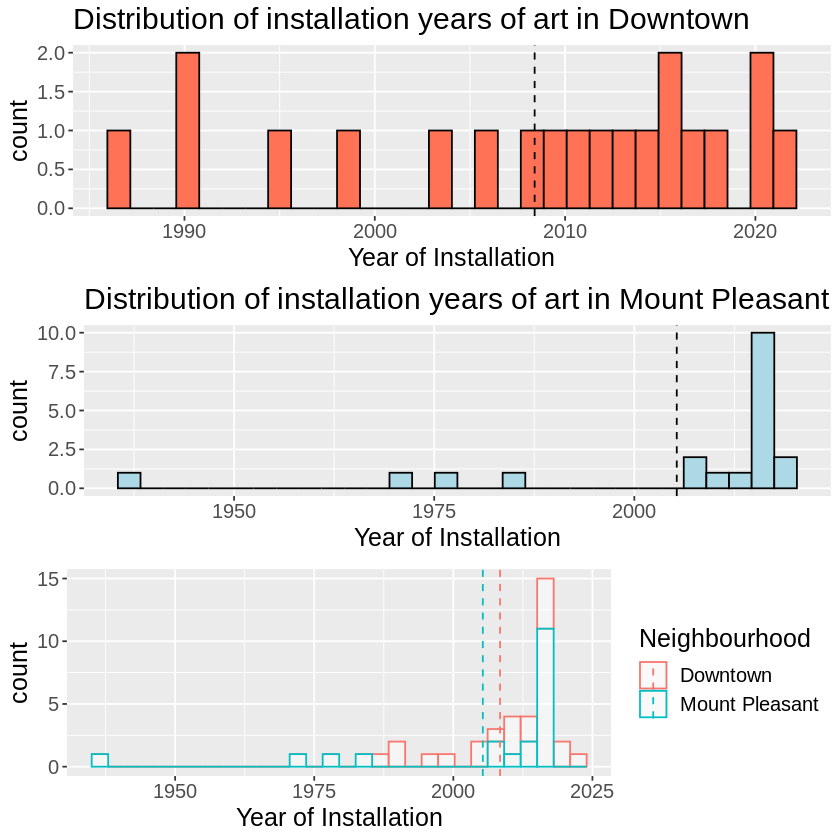

In [6]:
### Code to arrange the plots: Worksheet 8, 3.1
### Code for overlaid histograms:
#   http://www.sthda.com/english/wiki/ggplot2-histogram-plot-quick-start-guide-r-software-and-data-visualization

plots <- list()

# Downtown
plots[[1]] <- art_sample %>%
    filter(Neighbourhood == "Downtown") %>%
    ggplot() +
    geom_histogram(aes(x = YearOfInstallation), color = "black", fill = "coral1") +
    ggtitle("Distribution of installation years of art in Downtown") +
    xlab("Year of Installation") +
    theme(text = element_text(size = 15)) +
    geom_vline(aes(xintercept = downtown_mean), linetype = "dashed")

# Mount Pleasant
plots[[2]] <- art_sample %>%
    filter(Neighbourhood == "Mount Pleasant") %>%
    ggplot() +
    geom_histogram(aes(x = YearOfInstallation), color = "black", fill = "lightblue") +
    ggtitle("Distribution of installation years of art in Mount Pleasant") +
    xlab("Year of Installation") +
    theme(text = element_text(size = 15)) +
    geom_vline(aes(xintercept = pleasant_mean), linetype = "dashed")

# Overlaid histograms
plots[[3]] <- art_sample %>%
    ggplot(aes(x = YearOfInstallation, color = Neighbourhood)) +
    geom_histogram(fill="white", alpha = 0.5) +
    xlab("Year of Installation") +
    theme(text = element_text(size = 15)) +
    geom_vline(data = art_sample_stats, aes(xintercept = mean, color = Neighbourhood),
             linetype = "dashed")

grid.arrange(grobs = plots, ncol = 1)

Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”


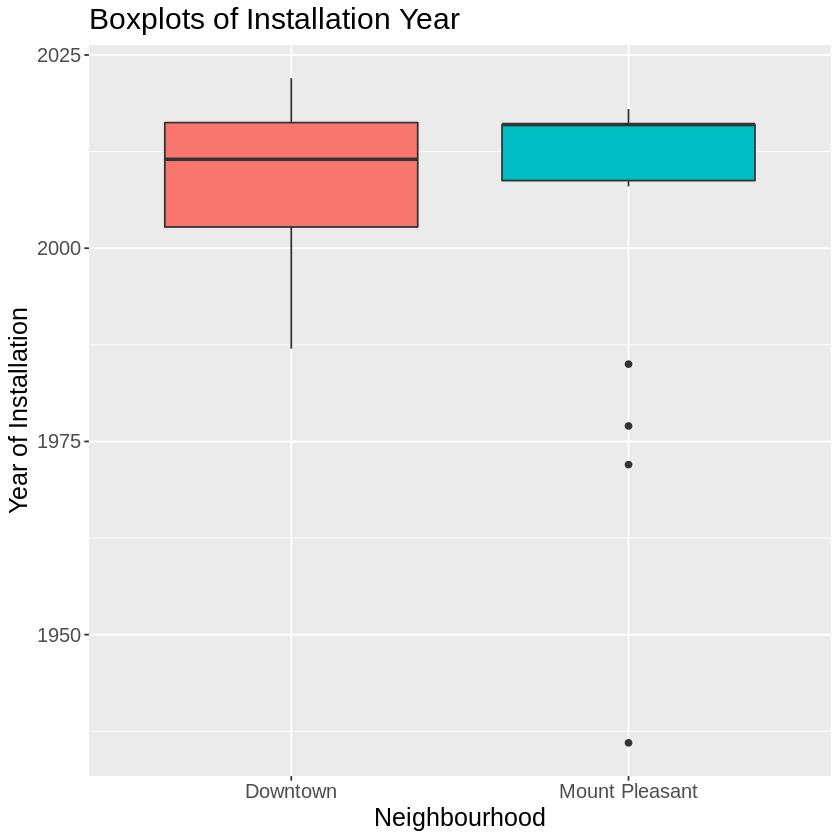

In [7]:
inst_year_boxplots <-
    art_sample %>% 
    ggplot() +
    geom_boxplot(aes(Neighbourhood, YearOfInstallation, fill = Neighbourhood)) +
    theme(text = element_text(size = 15)) +
    ggtitle("Boxplots of Installation Year") + 
    xlab("Neighbourhood") + 
    ylab("Year of Installation") + 
    guides(fill = FALSE)

inst_year_boxplots

# Assuming Data is not Population Data

Since we defined our data as a sample from the whole population, there is no need to take a further sample for our bootstrapping. We filtered our sample `art_data` into `art_data_required` by filtering for when  variable`Neighbourhood` was `Dowtown` or `Mount Pleasant`.

In [8]:
set.seed(11)

art_data_required <- art_data %>%
    filter(Neighbourhood == "Downtown" | Neighbourhood == "Mount Pleasant")

head(art_data_required)
glimpse(art_data_required)

Neighbourhood,YearOfInstallation
<chr>,<dbl>
Mount Pleasant,1948
Downtown,1966
Downtown,1967
Downtown,1966
Downtown,1910
Downtown,1969


Rows: 257
Columns: 2
$ Neighbourhood      <chr> "Mount Pleasant", "Downtown", "Downtown", "Downtown…
$ YearOfInstallation <dbl> 1948, 1966, 1967, 1966, 1910, 1969, 1924, 1969, 198…


**Null Distribution**

We then generated the null model (`pop_null_distribution`) from our sample using the infer package. 


In [9]:
#hypothesis testing via infer
set.seed(11)
pop_null_distribution <- art_data_required %>% 
    specify(formula = YearOfInstallation ~ Neighbourhood) %>% 
    hypothesize(null = "independence") %>% 
    generate(reps = 1000, type = "permute") %>% 
    calculate(stat = "diff in means", order = c("Downtown", "Mount Pleasant"))

head(pop_null_distribution)

replicate,stat
<int>,<dbl>
1,2.8542111
2,-0.7304549
3,-4.1324627
4,1.5984364
5,0.2741649
6,0.6394812


**Observed Difference in Means**

Here we looked at `art_data_required` to determine `pop_obs_diff_means`.

In [10]:
set.seed(11)

pop_obs_diff_means <- art_data_required %>% 
    specify(formula = YearOfInstallation ~ Neighbourhood) %>% 
    calculate(stat = "diff in means", order = c("Downtown", "Mount Pleasant"))

pop_obs_diff_means

pop_alpha <- pop_null_distribution %>% 
    get_confidence_interval(level = 0.90, type = "percentile")

pop_alpha

stat
<dbl>
-8.356432


lower_ci,upper_ci
<dbl>,<dbl>
-5.002372,5.413708


The value of `pop_obs_diff_means` for our alternative model, -8.356432, means the art was installed in Downtown Vancouver around 8 years sooner than in Mount Pleasant

**Confidence Interval from Null Model**

We generated a 90% confidence interval from the null model.

In [23]:
pop_alpha <- pop_null_distribution %>% 
    get_confidence_interval(level = 0.90, type = "percentile")

pop_alpha

lower_ci,upper_ci
<dbl>,<dbl>
-5.002372,5.413708


90% of the similated mean difference in years are captured by the intervals of -5.00 and 5.41


**Visualization**


We then compared our null model to our test statistic to see if statistically significant of a difference.

In [ ]:
visualize(pop_null_distribution, bins = 25) + 
    shade_p_value(obs_stat = pop_obs_diff_means, direction = "both") +
    shade_confidence_interval(endpoints = pop_alpha) +
    ggtitle("Null Model of Mean Difference in Years of Public Art vs Observed Difference") +
    xlab("difference in means")

Here is the p value produced: 

In [27]:
pop_p_value <- pop_null_distribution %>% 
    get_p_value(obs_stat = pop_obs_diff_means, direction = "both")

pop_p_value

p_value
<dbl>
0.002


Since 0.002 <<< 0.10, at a 0.10 significance level, we reject the null hypothesis that there is no difference in mean year of installation.

**Comparing Null Model to Bootstrapped Distribution**

Here we compared the null statistic of 0 to a bootstrapped sampling distribution using the `art_data_required` sample.

In [28]:
#hypothesis testing via infer
set.seed(11)

pop_bootstrap_distribution <- art_data_required %>% 
    specify(formula = YearOfInstallation ~ Neighbourhood) %>% 
    generate(reps = 1000, type = "bootstrap") %>% 
    calculate(stat = "diff in means", order = c("Downtown", "Mount Pleasant"))

head(pop_bootstrap_distribution)

replicate,stat
<int>,<dbl>
1,-8.843509
2,-6.770789
3,-11.001604
4,-6.540774
5,-14.079081
6,-7.033556


In [14]:
pop_percentile_ci <- pop_bootstrap_distribution %>% 
    get_confidence_interval(level = 0.90, type = "percentile")

pop_percentile_ci

lower_ci,upper_ci
<dbl>,<dbl>
-12.64673,-3.607743


We then produced a 90% condifence interval from the boostrap distribution. Below we visualized the bootstrapped distribution and overlaid the confidence interval (it is centered around `pop_obs_diff_means`). As you can see the null model is clearly not captured by the confidence interval.

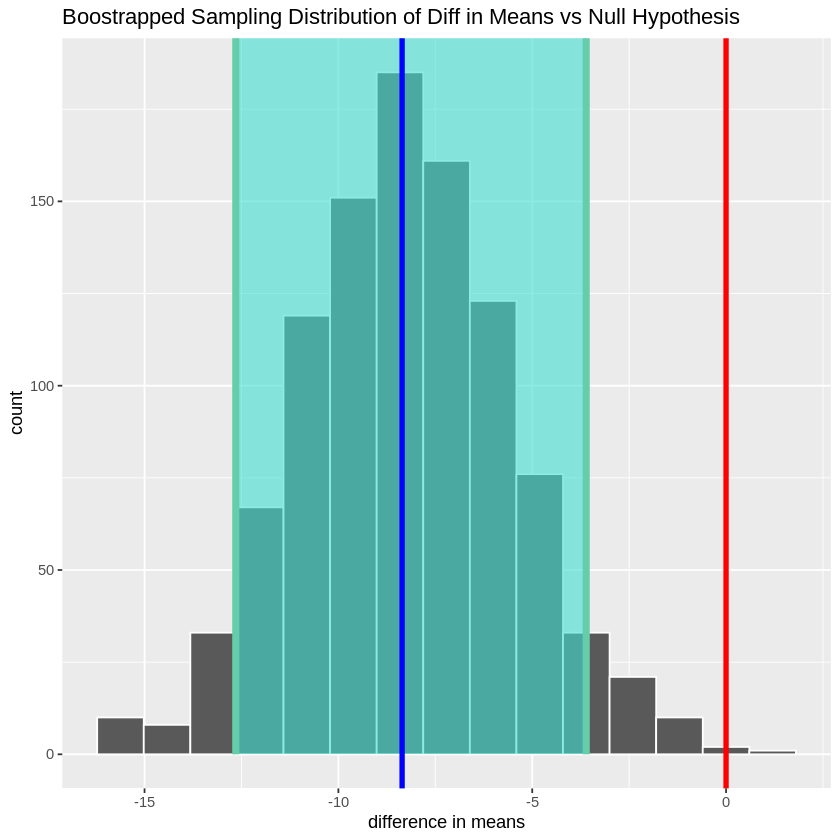

In [34]:
visualize(pop_bootstrap_distribution) + 
    shade_confidence_interval(endpoints = pop_percentile_ci) +
    geom_vline(xintercept = pull(pop_obs_diff_means), col = "blue", size = 1.5) + #alternative hypothesis
    geom_vline(xintercept = 0, col = "red", size = 1.5) + #null hypothesis
    ggtitle("Boostrapped Sampling Distribution of Diff in Means vs Null Hypothesis") +
    xlab("difference in means")

# Assuming Data is population data

In [16]:
set.seed(11)

sample_null_distribution <- art_sample %>% 
    specify(formula = YearOfInstallation ~ Neighbourhood) %>% 
    hypothesize(null = "independence") %>% 
    generate(reps = 1000, type = "permute") %>% 
    calculate(stat = "diff in means", order = c("Downtown", "Mount Pleasant"))

head(sample_null_distribution)

replicate,stat
<int>,<dbl>
1,-2.0
2,-0.9
3,4.6
4,-9.9
5,2.0
6,-4.7


In [17]:
set.seed(11)

sample_obs_diff_means <- art_sample %>% 
  specify(formula = YearOfInstallation ~ Neighbourhood) %>% 
  calculate(stat = "diff in means", order = c("Downtown", "Mount Pleasant"))

sample_obs_diff_means

stat
<dbl>
3.1


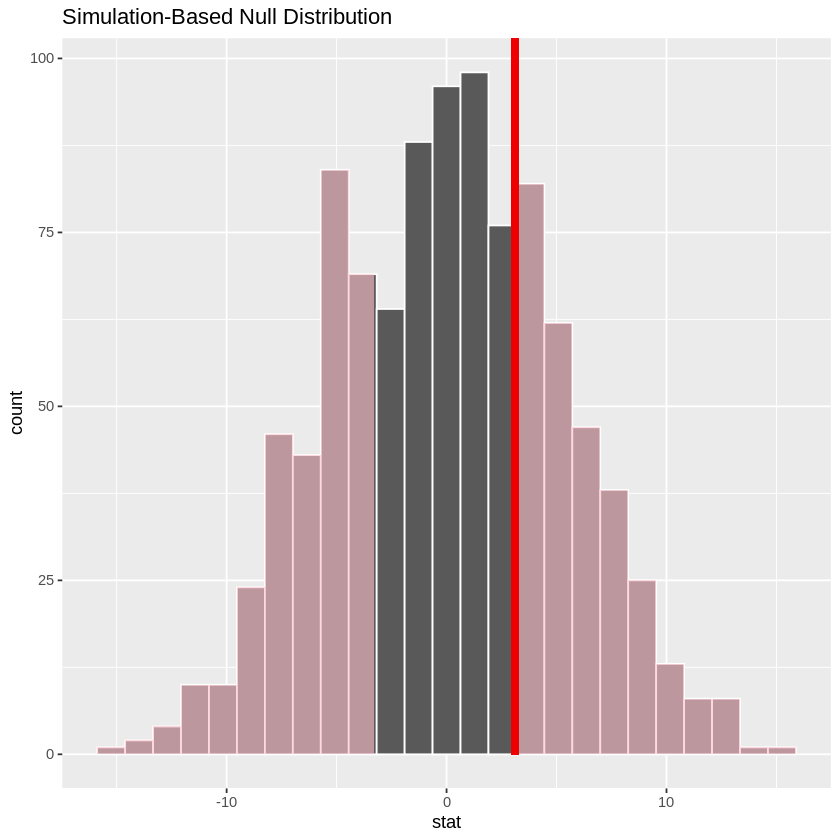

In [18]:
set.seed(11)

visualize(sample_null_distribution, bins = 25) + 
  shade_p_value(obs_stat = sample_obs_diff_means, direction = "both")

In [19]:
sample_p_value <- sample_null_distribution %>% 
    get_p_value(obs_stat = sample_obs_diff_means, direction = "both")

sample_p_value

p_value
<dbl>
0.582


In [20]:
#hypothesis testing via infer
set.seed(11)

sample_bootstrap_distribution <- art_sample %>% 
    specify(formula = YearOfInstallation ~ Neighbourhood) %>% 
    generate(reps = 1000, type = "bootstrap") %>% 
    calculate(stat = "diff in means", order = c("Downtown", "Mount Pleasant"))

head(sample_bootstrap_distribution)

replicate,stat
<int>,<dbl>
1,0.1666667
2,-1.0000000
3,4.8593350
4,-4.3021978
5,4.5087719
6,0.7708333


In [21]:
sample_percentile_ci <- sample_bootstrap_distribution %>% 
    get_confidence_interval(level = 0.90, type = "percentile")

sample_percentile_ci

lower_ci,upper_ci
<dbl>,<dbl>
-4.73584,12.492


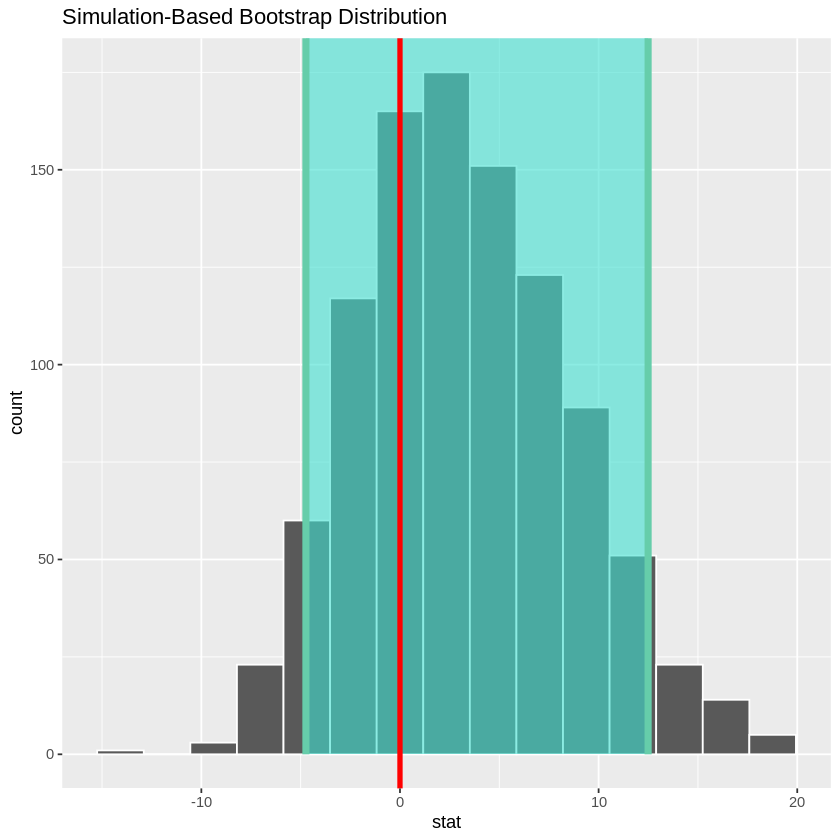

In [22]:
visualize(sample_bootstrap_distribution) + 
    shade_confidence_interval(endpoints = sample_percentile_ci) +
    geom_vline(xintercept = 0, col = "red", size = 1.5)

# Using CLT

In [67]:
set.seed(11)

#splitting it into two groups for two sample t-test
dt <- filter(art_data_required, Neighbourhood == 'Downtown')
mp <- filter(art_data_required, Neighbourhood == 'Mount Pleasant')
art_t_test <- tidy(
    t.test(x = dt$YearOfInstallation,
           y = mp$YearOfInstallation,
           alternative = "two.sided")
    )
#getting summary stats
vancouver_art_summary <- art_data_required %>%
    filter(!is.na(YearOfInstallation)) %>%
    group_by(Neighbourhood) %>%
    summarise(mean = mean(YearOfInstallation),
              var = var(YearOfInstallation),
              n = n()
              )
vancouver_art_summary


#calculating test statistic
art_test_stat <- (vancouver_art_summary$mean[1] - vancouver_art_summary$mean[2]) / 
                sqrt(vancouver_art_summary$var[2]/vancouver_art_summary$n[2] + 
                     vancouver_art_summary$var[1]/vancouver_art_summary$n[1])
art_test_stat

#calculating p value
art_p_value <-  2 * pt(abs(art_test_stat),
                      df = art_t_test$parameter[1],
                      lower.tail = FALSE)
art_p_value



qt(0.05, art_t_test$parameter[1])
qt(0.95, art_t_test$parameter[1])
?qt

art_t_test

Neighbourhood,mean,var,n
<chr>,<dbl>,<dbl>,<int>
Downtown,2000.572,489.3960,201
Mount Pleasant,2008.929,301.7403,56


[1] -2.987676

[1] 0.003468358

[1] -1.658853

[1] 1.658853

estimate,estimate1,estimate2,statistic,p.value,parameter,conf.low,conf.high,method,alternative
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
-8.356432,2000.572,2008.929,-2.987676,0.003468358,109.7728,-13.89949,-2.813372,Welch Two Sample t-test,two.sided


TDist {stats},R Documentation
"x, q",vector of quantiles.
p,vector of probabilities.
n,"number of observations. If length(n) > 1, the length is taken to be the number required."
df,"degrees of freedom (> 0, maybe non-integer). df = Inf is allowed."
ncp,"non-centrality parameter delta; currently except for rt(), only for abs(ncp) <= 37.62. If omitted, use the central t distribution."
"log, log.p","logical; if TRUE, probabilities p are given as log(p)."
lower.tail,"logical; if TRUE (default), probabilities are P[X ≤ x], otherwise, P[X > x]."
